In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import scipy.signal as sig
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
%matplotlib inline

In [2]:
labels = pd.read_csv('data_labels\REAL-PD_Training_Data_IDs_Labels.csv')
print(labels.shape)
null = pd.read_csv('null_solution.csv')

(591, 5)


In [3]:
tremor_preds=null[["subject_id", "tremor"]]
tremor_preds=tremor_preds.rename(columns={"tremor":"tremor_null"})

In [4]:
labels=pd.merge(labels, tremor_preds, how="left", on=["subject_id"])


0.0    136
1.0    114
2.0      6
Name: dyskinesia, dtype: int64


Text(0.5, 1.0, 'Dyskinesia')

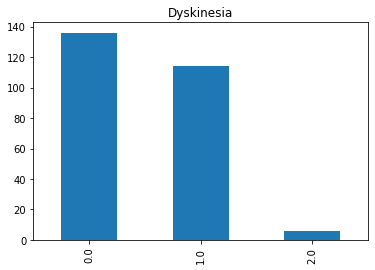

In [5]:
print(labels['dyskinesia'].value_counts())
labels['dyskinesia'].value_counts().plot(kind='bar')
plt.title('Dyskinesia')


Text(0.5, 1.0, 'Medication Distribution: REALPD')

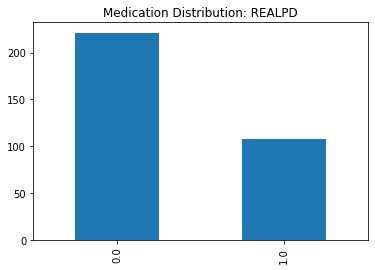

In [6]:
labels['on_off'].value_counts().sort_index().plot(kind='bar')
plt.title('Medication Distribution: REALPD')

Text(0, 0.5, 'Frequency')

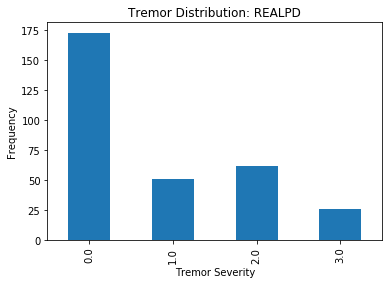

In [8]:
labels['tremor'].value_counts().sort_index().plot(kind='bar')
plt.title('Tremor Distribution: REALPD')
plt.xlabel('Tremor Severity')
plt.ylabel('Frequency')

In [8]:
pd.pivot_table(labels[["subject_id","tremor"]], index="subject_id", columns=["tremor"],aggfunc=len)

tremor,0.0,1.0,2.0,3.0
subject_id,,,,
hbv012,29.0,8.0,5.0,NaN
hbv013,49.0,12.0,5.0,1.0
hbv022,45.0,6.0,5.0,NaN
hbv023,NaN,2.0,36.0,8.0
hbv038,NaN,15.0,11.0,17.0
hbv054,50.0,8.0,NaN,NaN


In [9]:
"""define frequency bands the step fdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYUAAAEcCAYAAAAoSqjDAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAZ6UlEQVR4nO3deZRcdZ338feHoCiLgENABGNAcR+MGNAZRwe3GdxlXNERRDQw6uM2zzkiLugzbmfceXwUYURcIyrjiLvoKMqoQEAEFBSQgCExBFHZRcL3+aNuXyttd7q6qeqbTr9f59RJ3d/dvlWVvp+6S91fqgpJkgC26LoASdKmw1CQJLUMBUlSy1CQJLUMBUlSy1CQJLUMBW32kixIcn2SRUNa3huTHNs8v3eSoV3XnWTPJNcPa3nSdBkK81yzsRx73Jbkpr7h53dd31SSPK6pe6zmVUlOSvLQsWmqan1VbVtVVwywrJVTrbOq/q2qjhhC+TT17t+37F9V1bbDWPYU690ySSW5oe99e1eSLfqmOT3JzeP+j3xx3HLu3SznmEmWv3iCdb84yfpmedcm+UmSJzbjpvw8NVqGwjzXbCy3bTZEVwBP6Wv79Pjpk2w5+1VOue4rmvq3A/4GuAT4n/6N7SzUMFc9sHnvHgO8ADhk3Pgj+v+PVNWB48YfAlwDHJTkDtNY7w+a9e4IfAL4fJLtm3Gz9nnqLxkK2qgkb22+qS1Pch3wz0m2SHJUkkuTXJ3ks0l2bKYf++b4wuZb3jVJXpLkYUnOT/L7JB/oW/4WSd6U5PIkVyU5Mcldxi3r0CRXAN/aWK3V8+uqej1wIvDOZjkbfGtN8uQkFya5rqnx1c0G6cvAor5vqTtP8vrfmuTEce/TS5Ksbh6v7mv/VJI39w23eyNJlgN3B77erO814w9HJdk9yVea9/HiJC8a99ksb9ZxXZILkuwz4Ec7/r37JfBDYMmg8yQJvSB5HRDgSTNY73rgBGBrYI9x4yb8PDVahoIGcSDwGWB74CTgNfQ2AI8CdgduAI4ZN89S4F7APzfjjqT3bfRB9Dasj2ime3Ezzf7N9DsCHxi3rEcB92N6G53/BPZNcqcJxn0MOKyqtgP2Bk6rqj8AT6H5lto8rprk9U/kUcC9gScAbxjkW21VHQSsBp7QrO+9E0x2EnAZvfB4DvDvSf6+b/zTgU8COwBfp+9zSPKR8Yd1JpPk/sAj6H0rH9T+wC5NjZ8HDp7GvGPr3RI4DLgOuHQjk27s89QQGQoaxOlV9eWquq2qbgIOB46qqiur6mbgzcCz+49HA/9WVX+sqq8BtwCfqqp1VbUKOB14SDPd84F3V9VlVXUdcBTwvHHLOrqqbmzWPajV9P5/bz/BuD8BD0iyXVVdU1XnTPP1T+QtTY0/BT4OHDSNWieUZA9gP+DIqrq5qfNj9L6djzmtqr7ZfOP+JH3f9Kvq8Kp6xRSrOS/JDcDPgVOBj4wb/6Fm727scXTfuEOArzaB+hngSUn+asCX93dJfg/8Bngm8PTm85/Mxj5PDZGhoEH8etzwIuDLYxsK4HyggJ3HJqiqtX3T3wSMHx47mXp34PK+cZcDdwQWbmT9g9gNuA34wwTjDgSeClyR5HtJHjbFsgZZf/80l9N7XbfX3YGrq+qGccverW/4N33PbwS2meY69qZ37P559I7fbz1u/Euraoe+x1sAkmwDPAMYO+90OrCGwcPw9GZ5O1XV31bVf08x/cY+Tw2RoaBBjL/kchXw+HEbiztV1W8mmnkKq4F79g0vordnsa5d+cxu5XsgcFazJ7OBqjqjqp5KL8S+Anx2bNQkyxpk/ffoe76I3uuC3qG1/g3t3aax7NXATs0GuH/ZVw5Qz8CaPaDlwArgDQPO9gx6wX5ckt/QC4S7MYNDSAOa9PPUcBkKmoljgbenue6/OSH71BkuaznwmiSLk2wHvA1YXlW3TXdB6dk9yVuAF9I7FDV+mjsneV6Su1TVn+gdy17fjF5LbyO83QxexxubZf81vcMqY+cezqV3WGXHJLsC4w/nrAX2nGiBVXUZvQ3125NslWQJcCh//nY+bO8AjkiycMope6/xeOCv6R2yWkLvvMrS5vzEmK2S3KnvsWDQYgb5PDV8hoJm4r3AN4DvNFfk/BDYd4bLOp7eBvQHwK/obaRfOc1lLErvB1/XA2cADwAetZFDEocAlye5lt5JzhcAVNUFwMnAyubQ2M6TzD+R05v6vwW8o2/dJwIX0jvs8w3+vFcy5u3AW5r1vWqC5T4H2IveYaIv0DuX891BCkryH0k+OOgLqKpzgR8B/7uv+dhs+DuFM5svA/sD76+q3/Q9zgS+zYaXtV5E73Dh2KP/fMhkpvt5aohiJzuSpDHuKUiSWoaCJKllKEiSWoaCJKk1p2/utdNOO9XixYu7LkOS5pSzzz776qqa8NLjOR0KixcvZsWKFV2XIUlzSpLLJxvn4SNJUstQkCS1DAVJUmtkoZDkhPQ6Tbmgr+2kJOc2j5VJzm3aF6fXDeTYuGNHVZckaXKjPNF8IvBBel3tAVBVzxl7nuQ9bHgb3EurauBenyRJwzeyUKiq72eCTruh7cbv2fR64pIkbSK6OqfwSGBtVV3c17ZHkp8kOS3JIyebMcmyJCuSrFi3bt1kk0mSZqCrUDiI3n30x6wBFlXVQ+j1//uZNJ23j1dVx1XV0qpaunDhILd9lyQNatZDoemo+5/o6wC96cv3t83zs+l14H2f2a5Nkua7Ln7R/DjgoqYDdwCanp6uqar1Sfak16nIrzqojcVHfrWL1U7bync+qesSJG2GRnlJ6nJ6vTjdN8mqJIc1o57LhoeOoNeN33lJfkqvd6kjquqaUdUmSZrYKK8+OmiS9hdO0HYyvW4QJUkd8hfNkqSWoSBJahkKkqSWoSBJahkKkqSWoSBJahkKkqSWoSBJahkKkqSWoSBJahkKkqSWoSBJahkKkqSWoSBJahkKkqSWoSBJahkKkqSWoSBJahkKkqSWoSBJahkKkqTWyEIhyQlJrkpyQV/bm5NcmeTc5vHEvnGvS3JJkl8k+cdR1SVJmtwo9xROBA6YoP19VbWkeXwNIMkDgOcCD2zm+VCSBSOsTZI0gZGFQlV9H7hmwMmfBny2qv5YVZcBlwD7jao2SdLEujin8PIk5zWHl3Zs2nYDft03zaqm7S8kWZZkRZIV69atG3WtkjSvzHYofBi4F7AEWAO8p2nPBNPWRAuoquOqamlVLV24cOFoqpSkeWpWQ6Gq1lbV+qq6DTiePx8iWgXco2/S3YHVs1mbJGmWQyHJrn2DBwJjVyadAjw3yVZJ9gD2As6czdokSbDlqBacZDmwP7BTklXA0cD+SZbQOzS0EjgcoKp+luRzwM+BW4GXVdX6UdUmSZrYyEKhqg6aoPmjG5n+bcDbRlWPJGlq/qJZktQyFCRJLUNBktQyFCRJLUNBktQyFCRJLUNBktQyFCRJLUNBktQyFCRJLUNBktQyFCRJLUNBktQyFCRJLUNBktQyFCRJLUNBktQyFCRJLUNBktQyFCRJLUNBktQaWSgkOSHJVUku6Gt7V5KLkpyX5ItJdmjaFye5Kcm5zePYUdUlSZrcKPcUTgQOGNd2KvCgqtob+CXwur5xl1bVkuZxxAjrkiRNYmShUFXfB64Z1/atqrq1GfwxsPuo1i9Jmr4uzym8CPh63/AeSX6S5LQkj5xspiTLkqxIsmLdunWjr1KS5pFOQiHJ64FbgU83TWuARVX1EOA1wGeS3GWieavquKpaWlVLFy5cODsFS9I8MeuhkOQQ4MnA86uqAKrqj1X12+b52cClwH1muzZJmu9mNRSSHAC8FnhqVd3Y174wyYLm+Z7AXsCvZrM2SRJsOaoFJ1kO7A/slGQVcDS9q422Ak5NAvDj5kqjRwH/J8mtwHrgiKq6ZsIFS5JGZmShUFUHTdD80UmmPRk4eVS1SJIG4y+aJUktQ0GS1DIUJEktQ0GS1DIUJEktQ0GS1DIUJEktQ0GS1DIUJEktQ0GS1DIUJEmtgUIhyYNGXYgkqXuD7ikcm+TMJC9NssNIK5IkdWagUKiqvwOeD9wDWJHkM0keP9LKJEmzbuBzClV1MfAGep3k/D1wTJKLkvzTqIqTJM2uQc8p7J3kfcCFwGOAp1TV/Zvn7xthfZKkWTRoJzsfBI4Hjqqqm8Yaq2p1kjeMpDJJ0qwbNBSeCNxUVesBkmwB3KmqbqyqT46sOknSrBr0nMK3gTv3DW/dtEmSNiODhsKdqur6sYHm+dajKUmS1JVBQ+GGJPuMDSR5KHDTRqaXJM1Bg4bCq4DPJ/lBkh8AJwEvn2qmJCckuSrJBX1td01yapKLm393bNqT5JgklyQ5rz+EJEmzY9Afr50F3A/4F+ClwP2r6uwBZj0ROGBc25HAd6pqL+A7zTDAE4C9mscy4MOD1CZJGp7p3BBvX2Bv4CHAQUkOnmqGqvo+cM245qcBH2+efxx4el/7J6rnx8AOSXadRn2SpNtpoEtSk3wSuBdwLrC+aS7gEzNY5y5VtQagqtYk2blp3w34dd90q5q2NeNqWUZvT4JFixbNYPWSpMkM+juFpcADqqpGWEsmaPuL9VXVccBxAEuXLh1lPZI07wx6+OgC4G5DWufascNCzb9XNe2r6N1wb8zuwOohrVOSNIBBQ2En4OdJvpnklLHHDNd5CnBI8/wQ4Et97Qc3VyE9HPjD2GEmSdLsGPTw0ZtnsvAky4H9gZ2SrAKOBt4JfC7JYcAVwLOayb9G73YalwA3AofOZJ2SpJkbKBSq6rQk9wT2qqpvJ9kaWDDAfAdNMuqxE0xbwMsGqUeSNBqD3jr7JcAXgI80TbsB/zWqoiRJ3Rj0nMLLgEcA10Lb4c7OG51DkjTnDBoKf6yqW8YGkmzJBJeLSpLmtkFD4bQkRwF3bvpm/jzw5dGVJUnqwqChcCSwDjgfOJzelUL2uCZJm5lBrz66jV53nMePthxJUpcGvffRZUx8y4k9h16RJKkz07n30Zg70fvB2V2HX44kqUuD9qfw277HlVX1fuAxI65NkjTLBj181N8L2hb09hy2G0lFkqTODHr46D19z28FVgLPHno1kqRODXr10aNHXYgkqXuDHj56zcbGV9V7h1OOJKlL07n6aF96fR4APAX4Pht2nylJmuMGDYWdgH2q6jqAJG8GPl9VLx5VYZKk2TfobS4WAbf0Dd8CLB56NZKkTg26p/BJ4MwkX6T3y+YDgU+MrCpJUicGvfrobUm+DjyyaTq0qn4yurIkSV0Y9PARwNbAtVX1AWBVkj1GVJMkqSODdsd5NPBa4HVN0x2AT42qKElSNwbdUzgQeCpwA0BVrcbbXEjSZmfQE823VFUlKYAk28x0hUnuC5zU17Qn8CZgB+Al9DrzATiqqr420/VIkqZv0FD4XJKPADskeQnwImbY4U5V/QJYApBkAXAl8EXgUOB9VfXumSxXknT7DXr10bubvpmvBe4LvKmqTh3C+h8LXFpVlycZwuIkSbfHlKHQfJv/ZlU9DhhGEPR7LrC8b/jlSQ4GVgD/WlW/m6CeZcAygEWLFg25HEma36Y80VxV64Ebk2w/zBUnuSO9k9efb5o+DNyL3qGlNWx4u+7+eo6rqqVVtXThwoXDLEmS5r1BzyncDJyf5FSaK5AAquoVt2PdTwDOqaq1zbLWjo1IcjzwlduxbEnSDAwaCl9tHsN0EH2HjpLsWlVrmsEDgQuGvD5J0hQ2GgpJFlXVFVX18WGuNMnWwOOBw/ua/z3JEnr3Vlo5bpwkaRZMtafwX8A+AElOrqpnDGOlVXUj8Ffj2l4wjGVLkmZuqhPN/deJ7jnKQiRJ3ZsqFGqS55KkzdBUh48enORaensMd26e0wxXVd1lpNVJkmbVRkOhqhbMViGSpO5Npz8FSdJmzlCQJLUMBUlSy1CQJLUMBUlSy1CQJLUGvSGepE3A4iOHfV/K0Vj5zid1XYJmyD0FSVLLUJAktQwFSVLLUJAktQwFSVLLUJAktQwFSVLLUJAktQwFSVLLUJAktTq7zUWSlcB1wHrg1qpamuSuwEnAYmAl8Oyq+l1XNUrSfNP1nsKjq2pJVS1tho8EvlNVewHfaYYlSbNkU7sh3tOA/ZvnHwe+B7y2q2J0+3kDN2lu6XJPoYBvJTk7ybKmbZeqWgPQ/Lvz+JmSLEuyIsmKdevWzWK5krT563JP4RFVtTrJzsCpSS4aZKaqOg44DmDp0qU1ygIlab7pbE+hqlY3/14FfBHYD1ibZFeA5t+ruqpPkuajTkIhyTZJtht7DvwDcAFwCnBIM9khwJe6qE+S5quuDh/tAnwxyVgNn6mqbyQ5C/hcksOAK4BndVSfJM1LnYRCVf0KePAE7b8FHjv7FUmSoPvfKUiSNiGGgiSpZShIklqGgiSpZShIklqGgiSpZShIklqGgiSpZShIklqGgiSpZShIklqGgiSpZShIklqGgiSpZShIklqGgiSpZShIklqGgiSpZShIklqGgiSpZShIklqzHgpJ7pHku0kuTPKzJK9s2t+c5Mok5zaPJ852bZI0323ZwTpvBf61qs5Jsh1wdpJTm3Hvq6p3d1CTJIkOQqGq1gBrmufXJbkQ2G2265A0vy0+8qtdlzCQle980qyur9NzCkkWAw8BzmiaXp7kvCQnJNlxknmWJVmRZMW6detmqVJJmh86C4Uk2wInA6+qqmuBDwP3ApbQ25N4z0TzVdVxVbW0qpYuXLhw1uqVpPmgk1BIcgd6gfDpqvpPgKpaW1Xrq+o24Hhgvy5qk6T5rIurjwJ8FLiwqt7b175r32QHAhfMdm2SNN91cfXRI4AXAOcnObdpOwo4KMkSoICVwOEd1CZJ81oXVx+dDmSCUV+b7VokSRvyF82SpJahIElqGQqSpJahIElqGQqSpJahIElqGQqSpJahIElqGQqSpJahIElqGQqSpJahIElqGQqSpJahIElqGQqSpJahIElqGQqSpJahIElqGQqSpJahIElqGQqSpNYmFwpJDkjyiySXJDmy63okaT7ZpEIhyQLg/wFPAB4AHJTkAd1WJUnzxyYVCsB+wCVV9auqugX4LPC0jmuSpHkjVdV1Da0kzwQOqKoXN8MvAB5WVS/vm2YZsKwZvC/wi1kvdPp2Aq7uuojNiO/ncPl+Ds9ceS/vWVULJxqx5WxXMoVM0LZBalXVccBxs1POcCRZUVVLu65jc+H7OVy+n8OzObyXm9rho1XAPfqGdwdWd1SLJM07m1oonAXslWSPJHcEnguc0nFNkjRvbFKHj6rq1iQvB74JLABOqKqfdVzWMMypw11zgO/ncPl+Ds+cfy83qRPNkqRubWqHjyRJHTIUJEktQ0GS1DIURijJXZPs2HUdkkZrc/pbNxSGLMmiJJ9Nsg44AzgryVVN2+Juq5MgyS5J9knykCS7dF3PXLW5/q179dGQJfkR8H7gC1W1vmlbADwLeFVVPbzL+uaqZuO1G71fuK+uqrUdlzTnJFkCHAtsD1zZNO8O/B54aVWd01Vtc9Hm+rduKAxZkouraq/pjtPE3JANT5JzgcOr6oxx7Q8HPlJVD+6msrlpc/1b36R+vLaZODvJh4CPA79u2u4BHAL8pLOq5q4TmXxD9jHADdngthn/PgJU1Y+TbNNFQXPcZvm37p7CkDW35ziM3i2/d6N3k79fA18GPlpVf+ywvDlnim9jl1TVvWe7prkqyTHAvYBPsOFG7GDgsv67EWtqm+vfuqGgTZobsuFK8gQ23IitAk6pqq91Wpg2GYbCLEry5Kr6Std1zDVuyDTXzOW/dc8pzK59gTn5H6VLVfV14Otd17E5S7Ks6atEwzFn/9YNhRFIcj/+/M226PUJcUpVHd1pYZsZN2RDNVEHV5pCkv2Aqqqzmv7kDwAumst/6/54bciSvJZe39IBzqTXR0SA5UmO7LK2zZAbsmlKcr8kj02y7bhRl3dS0ByW5GjgGODDSd4BfBDYFjgyyes7Le528JzCkCX5JfDAqvrTuPY7Aj+bq9cub4qSHFpVH+u6jrkiySuAlwEXAkuAV1bVl5px51TVPl3WN9ckOZ/e+7gV8Btg96q6NsmdgTOqau9OC5wh9xSG7zbg7hO079qM0/C8pesC5piXAA+tqqcD+wNvTPLKZpx7XdN3a1Wtr6obgUur6lqAqrqJOfy37jmF4XsV8J0kF/PnSygXAfcGvHxympKcN9kowPv2TM+CqroeoKpWJtkf+EKSe2IozMQtSbZuQuGhY41JtmcOh4KHj0YgyRbAfmx4CeVZY/dH0eCSrAX+Efjd+FHAD6tqor0yTSDJfwOvqapz+9q2BE4Anl9VCzorbg5KstVEP1BLshOwa1Wd30FZt5t7CiNQVbcBP+66js3EV4Bt+zdkY5J8b/bLmdMOBm7tb6iqW4GDk3ykm5Lmrsl+sVxVVwNXz3I5Q+OegiSp5YlmSVLLUJAktQwFaUBJXp/kZ0nOS3JukodNc/7FSS4YVX3SMHiiWRpAkr8BngzsU1V/bK4wuWPHZUlD556CNJhdgavHrjipqquranWSfZP8MMlPk5yZZLtmj+AHSc5pHn87fmFJFiR5V5Kzmj2Pw2f9FUkT8OojaQDNvYJOB7YGvg2cBPwIuAh4TnNDtLsAN9Lbg7itqm5OshewvKqWNp25f6WqHpRkGbBzVb01yVbA/wDPqqrLZv3FSX08fCQNoKquT/JQ4JHAo+mFwtuANVV1VjPNtQBN15YfbPqXXg/cZ4JF/gOwd5JnNsPbA3sBhoI6ZShIA2p+kf494HvNzdBeRu/W6OO9GlhLr//oLYCbJ5gmwP+qqm+OplppZjynIA0gyX2bQ0FjltC72+jdk+zbTLNdc9uI7entQdwGvACY6PYR3wT+Jckdmnnv0+xhSJ1yT0EazLbA/02yA71bRVwCLAM+1rTfGbgJeBzwIeDkJM8CvgvcMMHy/gNYDJyTJMA64OmjfhHSVDzRLElqefhIktQyFCRJLUNBktQyFCRJLUNBktQyFCRJLUNBktT6/55KNuPOnJFsAAAAAElFTkSuQmCCunction"""
W_n = [3,7];

"""Select the step function"""
Ord = sig.buttord(wp = [4,6],ws =[3,7],gpass =0.08, gstop = 10,fs = 50)
Filter = sig.butter(Ord[0],Wn = W_n,btype = 'bandpass',fs =50);

Text(0.5, 0, 'Frequency[Hz]')

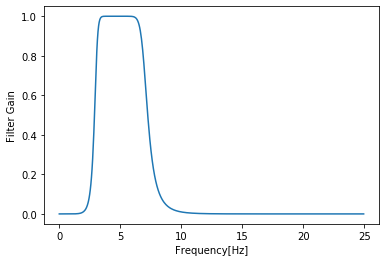

In [10]:
"""Plot the frequency response"""
Response = sig.freqz(Filter[0],Filter[1],fs=50)

plt.plot(Response[0],np.abs(Response[1]))
plt.ylabel("Filter Gain");
plt.xlabel("Frequency[Hz]")

In [11]:

#pd.read_csv(f) for f in all_filenames 

mycsvdir = 'training_data\REAL_training\smartphone_accelerometer'

csvfiles = glob.glob(os.path.join(mycsvdir, '*.csv'))

Means_sa=[]
for csvfile in csvfiles:
    df = pd.read_csv(csvfile)
    
    #Relevant features 
    measurement_id = os.path.basename(csvfile)
    measurement_id = measurement_id.replace(".csv","")
    
    df["r"] = np.sqrt(df.x**2+df.y**2+df.z**2)
    dr = np.sqrt(np.diff(df.x)**2+np.diff(df.y)**2+np.diff(df.z)**2)
    mean_r = np.median(df.r)
    std_r = np.std(df.r)
    min_r = np.min(df.r)
    max_r = np.max(df.r)
    skew_r = skew(df.r)
    kurtosis_r = kurtosis(df.r)
    
    peaks_r = len(sig.find_peaks(df.r, threshold = 3*std_r)[0])/(df["t"].iloc[-1]/60)
    #peaks_freq
    
    #divide sum of squares of peaks by sum of squares of r
    
    
    mean_dr = np.median(dr)
    std_dr = np.std(dr)
    min_dr = np.min(dr)
    max_dr = np.max(dr)
    skew_dr = skew(dr)
    kurtosis_dr = kurtosis(dr)
    
    """Extract frequency bands in Hz"""
    FreqBandx = sig.lfilter(Filter[0],Filter[1],df["x"]);
    FreqBandy = sig.lfilter(Filter[0],Filter[1],df["y"]);
    FreqBandz = sig.lfilter(Filter[0],Filter[1],df["z"]);
    
    """Find the power in each frequency Band"""
    PowerFreqBandx = np.abs(FreqBandx)**2;
    PowerFreqBandy = np.abs(FreqBandy)**2;
    PowerFreqBandz = np.abs(FreqBandz)**2;
    
    """Sum the power in each frequency band"""
    SumPowerFreqBandx = np.sum(PowerFreqBandx);
    SumPowerFreqBandy = np.sum(PowerFreqBandy);
    SumPowerFreqBandz = np.sum(PowerFreqBandz);
    
    """Sum the total signal power"""
    Powerx = np.sum(df["x"]**2);
    Powery = np.sum(df["y"]**2);
    Powerz = np.sum(df["z"]**2);
    
    """Find the percentage of power in frequencies of interest"""
    FreqPower = np.sqrt((SumPowerFreqBandx+SumPowerFreqBandy+SumPowerFreqBandz)/(Powerx+Powery+Powerz));
    
    Means_sa.append([measurement_id, mean_r, std_r, min_r, max_r, skew_r, kurtosis_r, peaks_r,
                     mean_dr,std_dr, min_dr, max_dr, skew_dr, kurtosis_dr,FreqPower])
   

In [12]:
accel_phones= pd.DataFrame(Means_sa, columns=["measurement_id", "mean_r_sa", "std_r_sa", 
                                              "min_r_sa", "max_r_sa", "skew_r_sa", "kurtosis_r_sa","peaks_r_sa",
                                              "mean_dr_sa", "std_dr_sa", "min_dr_sa", "max_dr_sa", 
                                              "skew_dr_sa", "kurtosis_dr_sa","FreqPower_sa"])
   



In [13]:
accel_phones.head()

,measurement_id,mean_r_sa,std_r_sa,min_r_sa,max_r_sa,skew_r_sa,kurtosis_r_sa,peaks_r_sa,mean_dr_sa,std_dr_sa,min_dr_sa,max_dr_sa,skew_dr_sa,kurtosis_dr_sa,FreqPower_sa
0,00a49337-386c-4de3-a220-4cf3c0d20a7d,10.348021,0.142331,5.148181,17.978439,6.201954,475.003586,4.250018,0.030320,0.133402,0.000000,8.723960,18.316883,606.819719,0.010864
1,00e19ae8-3da9-4e76-b9f6-3f565b3e5f06,9.597891,0.020552,8.434835,10.630479,-0.547084,392.166340,9.450079,0.027086,0.039381,0.000000,3.838616,38.758691,2442.798342,0.003252
2,00f1d52e-03cf-4031-a616-9a66f961d994,9.472367,0.527928,0.954803,35.897640,12.004225,324.081339,1.050010,0.027087,0.402850,0.000000,34.862598,26.024588,1300.129813,0.043302
3,0148fd23-2066-4fb4-aadb-9ba294ed4ab1,9.725121,0.481252,4.733335,23.594657,9.213878,174.505308,0.550002,0.037188,0.247675,0.001197,12.184761,16.754113,471.948107,0.023674
4,014ccd5a-7f4a-480b-8ab5-1ed8601d0721,9.737473,0.554874,2.134904,27.962365,5.743465,94.241887,0.250001,0.030096,0.206478,0.000000,26.711065,27.504339,1966.497735,0.024835


In [14]:
accel_phones.peaks_r_sa[0]

4.250017708407119

In [15]:

#pd.read_csv(f) for f in all_filenames 

mycsvdir = 'training_data\REAL_training\smartwatch_accelerometer'

csvfiles = glob.glob(os.path.join(mycsvdir, '*.csv'))

Means_wa=[]
for csvfile in csvfiles:
    df1 = pd.read_csv(csvfile)
    
    for x in pd.Series(df1['device_id']).unique():
        
        df = df1[df1['device_id']==x]
        
        #Relevant features 
        measurement_id = os.path.basename(csvfile)
        measurement_id = measurement_id.replace(".csv","")
        
        device_id = x
        
        df["r"] = np.sqrt(df.x**2+df.y**2+df.z**2)
        dr = np.sqrt(np.diff(df.x)**2+np.diff(df.y)**2+np.diff(df.z)**2)

        mean_r = np.mean(df.r)
        std_r = np.std(df.r)
        min_r = np.min(df.r)
        max_r = np.max(df.r)
        skew_r = skew(df.r)
        kurtosis_r = kurtosis(df.r)
        
        peaks_r = len(sig.find_peaks(df.r, threshold = 3*std_r)[0])/(df["t"].iloc[-1]/60)

        mean_dr = np.mean(dr)
        std_dr = np.std(dr)
        min_dr = np.min(dr)
        max_dr = np.max(dr)
        skew_dr = skew(dr)
        kurtosis_dr = kurtosis(dr)
        
        """Extract frequency bands in Hz"""
        FreqBandx = sig.lfilter(Filter[0],Filter[1],df["x"]);
        FreqBandy = sig.lfilter(Filter[0],Filter[1],df["y"]);
        FreqBandz = sig.lfilter(Filter[0],Filter[1],df["z"]);

        """Find the power in each frequency Band"""
        PowerFreqBandx = np.abs(FreqBandx)**2;
        PowerFreqBandy = np.abs(FreqBandy)**2;
        PowerFreqBandz = np.abs(FreqBandz)**2;

        """Sum the power in each frequency band"""
        SumPowerFreqBandx = np.sum(PowerFreqBandx);
        SumPowerFreqBandy = np.sum(PowerFreqBandy);
        SumPowerFreqBandz = np.sum(PowerFreqBandz);

        """Sum the total signal power"""
        Powerx = np.sum(df["x"]**2);
        Powery = np.sum(df["y"]**2);
        Powerz = np.sum(df["z"]**2);

        """Find the percentage of power in frequencies of interest"""
        FreqPower = np.sqrt((SumPowerFreqBandx+SumPowerFreqBandy+SumPowerFreqBandz)/(Powerx+Powery+Powerz));

        Means_wa.append([measurement_id, device_id, mean_r, std_r, min_r, max_r, skew_r, kurtosis_r, peaks_r,
                         mean_dr,std_dr, min_dr, max_dr, skew_dr, kurtosis_dr,FreqPower])



C:\Users\lisbe\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
accel_watches= pd.DataFrame(Means_wa, columns=["measurement_id","device_id", "mean_r_wa", "std_r_wa", 
                                              "min_r_wa", "max_r_wa", "skew__r_wa", "kurtosis_r_wa", "peaks_r_wa",
                                              "mean_dr_wa", "std_dr_wa", "min_dr_wa", "max_dr_Wa", 
                                              "skew_dr_wa", "kurtosis_dr_wa","FreqPower_wa"])
   




In [17]:
accel_watches.shape

(676, 16)

In [18]:
#pd.read_csv(f) for f in all_filenames 

mycsvdir ='training_data\REAL_training\smartwatch_gyroscope'
csvfiles = glob.glob(os.path.join(mycsvdir, '*.csv'))

Means_wg=[]
for csvfile in csvfiles:
    df1 = pd.read_csv(csvfile)
    
    for x in pd.Series(df1['device_id']).unique():
        
        df = df1[df1['device_id']==x]
        
        #Relevant features 
        measurement_id = os.path.basename(csvfile)
        measurement_id = measurement_id.replace(".csv","")
        
        device_id = x
        
        df["r"] = np.sqrt(df.x**2+df.y**2+df.z**2)
        mean_r = np.mean(df.r)
        std_r = np.std(df.r)
        min_r = np.min(df.r)
        max_r = np.max(df.r)
        skew_r = skew(df.r)
        kurtosis_r = kurtosis(df.r)
        peaks_r = len(sig.find_peaks(df.r, threshold = 3*std_r)[0])/(df["t"].iloc[-1]/60)
    
        Means_wg.append([measurement_id, device_id, mean_r, std_r, min_r, max_r, skew_r, kurtosis_r, peaks_r])

C:\Users\lisbe\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:

gyro_watches= pd.DataFrame(Means_wg, columns=["measurement_id", "device_id", "mean_r_wg", "std_r_wg", 
                                              "min_r_wg", "max_r_wg", "skew_r_wg", "kurtosis_r_wg", "peaks_r_wg"])
   



In [20]:
gyro_watches.shape

(676, 9)

In [21]:
df_watch=pd.merge(gyro_watches, accel_watches, on=["measurement_id", "device_id"])

In [22]:
df_watch.head()

,measurement_id,device_id,mean_r_wg,std_r_wg,min_r_wg,max_r_wg,skew_r_wg,kurtosis_r_wg,peaks_r_wg,mean_r_wa,...,skew__r_wa,kurtosis_r_wa,peaks_r_wa,mean_dr_wa,std_dr_wa,min_dr_wa,max_dr_Wa,skew_dr_wa,kurtosis_dr_wa,FreqPower_wa
0,00e19ae8-3da9-4e76-b9f6-3f565b3e5f06,2WLT,0.932274,1.278240,0.002601,31.765899,3.484675,24.045193,0.052074,10.223686,...,9.981298,397.013541,3.645083,0.696498,1.314481,0.0,99.864372,25.031319,1278.002378,0.085131
1,00f1d52e-03cf-4031-a616-9a66f961d994,2WH3,0.252978,0.672540,0.000000,10.770546,5.556545,43.863053,0.050000,9.999994,...,7.923019,205.116477,1.700001,0.334225,0.688596,0.0,27.285312,13.831569,343.976648,0.054035
2,00f1d52e-03cf-4031-a616-9a66f961d994,327T,0.014950,0.001085,0.004379,0.040216,4.059588,73.975621,9.150015,9.941846,...,0.005258,-0.046104,7.700071,0.123816,0.055928,0.0,0.445733,0.414507,0.288822,0.004877
3,0148fd23-2066-4fb4-aadb-9ba294ed4ab1,2VSP,0.162565,0.396840,0.000000,7.508131,6.063991,54.367232,0.050001,10.034424,...,4.404967,75.490450,1.550023,0.279992,0.426392,0.0,24.006040,11.505342,344.097680,0.038738
4,014ccd5a-7f4a-480b-8ab5-1ed8601d0721,2ZX6,0.623736,1.023886,0.000000,15.372604,2.861452,12.277611,21.100141,10.404072,...,23.876457,1498.962897,45.900153,1.458589,2.860483,0.0,144.170348,11.011365,326.431559,0.064473


In [23]:
accel_phones.shape

(526, 15)

In [24]:
df_train = pd.merge(df_watch, accel_phones, on=["measurement_id"], how='outer')
df_train.shape

(732, 37)

In [25]:
labels_tremor = labels.drop(['on_off', 'dyskinesia'], axis=1)

In [26]:
labels_tremor = labels_tremor.dropna()
labels_tremor.shape

(312, 4)

In [27]:
df_tremor= pd.merge(df_train, labels_tremor, on=["measurement_id"], how='right')


In [28]:
df_tremor.shape

(370, 40)

In [29]:
len(df_tremor.subject_id.unique())

6

In [30]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_tremor, test_size=0.2, random_state=42, stratify = df_tremor['subject_id'])

In [31]:
train.head()

,measurement_id,device_id,mean_r_wg,std_r_wg,min_r_wg,max_r_wg,skew_r_wg,kurtosis_r_wg,peaks_r_wg,mean_r_wa,...,mean_dr_sa,std_dr_sa,min_dr_sa,max_dr_sa,skew_dr_sa,kurtosis_dr_sa,FreqPower_sa,subject_id,tremor,tremor_null
288,dd8a49e5-01d9-4b66-ac2d-9af92ad24d49,2WH8,0.345821,0.532731,0.005719,8.844716,4.659606,35.521744,0.000000,10.313129,...,0.061949,0.256077,0.001197,16.580322,11.185084,337.502845,0.027706,hbv013,0.0,0.373134
160,7b333456-c42c-48c7-88cc-046c46c5e465,2WH3,0.006854,0.000723,0.003358,0.019351,0.407942,3.725164,6.100025,10.059251,...,0.038308,0.763964,0.000000,25.601324,10.497249,169.126711,0.093733,hbv023,3.0,2.130435
35,23370d63-278b-4352-a580-e15dd15aad6c,2ZX6,0.258138,0.613130,0.001502,14.528295,4.866213,40.103600,1.800012,10.160091,...,0.026008,0.134101,0.000000,14.350957,23.000949,1296.160908,0.013459,hbv054,0.0,0.137931
118,5949b311-1eed-4fa1-b053-30d5c8b11954,2WH5,0.292375,0.556250,0.001062,9.385382,4.230119,27.219064,0.000000,10.217263,...,0.037494,0.333719,0.000000,27.517543,19.978334,824.155413,0.029939,hbv022,0.0,0.285714
124,5c42911d-0ebd-47ba-9925-dd5ab1c0ed61,2VSP,0.011198,0.000651,0.008628,0.013887,-0.045891,0.010925,1.100019,10.091634,...,0.035892,0.307609,0.000000,21.197570,19.224398,737.034604,0.025984,hbv013,1.0,0.373134


In [32]:
cols_to_transform=train.columns[2:-3]

In [33]:

scaler= StandardScaler()
#scaler=MinMaxScaler()
scaler= scaler.fit(train[cols_to_transform])
train[cols_to_transform] = scaler.transform(train[cols_to_transform])
test[cols_to_transform] = scaler.transform(test[cols_to_transform])


C:\Users\lisbe\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\lisbe\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\lisbe\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [34]:
X_train = train.drop(['tremor','measurement_id', 'device_id', 'tremor_null'], axis=1)
print(X_train.shape)
y_train = train.tremor
null_train = train.tremor_null
X_test = test.drop(['tremor', 'measurement_id', 'device_id', 'tremor_null'], axis=1)
print(X_test.shape)
y_test = test.tremor
null_test = test.tremor_null

(296, 36)
(74, 36)


In [35]:
imputer = SimpleImputer(strategy="median")


In [36]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

print(X_train.shape)
print(X_test.shape)

(296, 41)
(74, 41)


In [37]:
X_test.head()

,mean_r_wg,std_r_wg,min_r_wg,max_r_wg,skew_r_wg,kurtosis_r_wg,peaks_r_wg,mean_r_wa,std_r_wa,min_r_wa,...,max_dr_sa,skew_dr_sa,kurtosis_dr_sa,FreqPower_sa,subject_id_hbv012,subject_id_hbv013,subject_id_hbv022,subject_id_hbv023,subject_id_hbv038,subject_id_hbv054
103,0.114880,0.537804,-0.415333,0.207832,-0.132305,-0.102678,-0.384465,-0.970291,0.225553,-1.068903,...,-0.582190,-0.585963,-0.437754,0.247629,0,0,0,1,0,0
221,3.976882,2.657819,0.700869,2.012369,-0.234492,-0.107148,-0.370135,0.774121,2.341807,-0.991801,...,0.546701,-0.532439,-0.414824,0.577295,1,0,0,0,0,0
284,-0.061714,0.535618,-0.301411,0.779932,-0.045910,-0.095967,-0.355805,0.316926,0.580012,-0.739748,...,0.365280,0.028675,-0.114435,-0.583756,0,0,0,0,0,1
355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.543749,-0.460853,-0.407431,-0.452485,0,1,0,0,0,0
56,0.582083,1.154887,-0.301411,0.725593,-0.170153,-0.104747,3.828491,-1.063000,0.578575,-1.069602,...,-0.111380,-0.474335,-0.396066,-0.059139,0,0,0,1,0,0


In [38]:
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns = X_train.columns)
print(X_train_imputed.shape)
print(y_train.shape)
X_test_imputed = pd.DataFrame(imputer.fit_transform(X_test), columns = X_test.columns)
print(X_test_imputed.shape)
print(y_test.shape)

(296, 41)
(296,)
(74, 41)
(74,)


In [60]:
knn = KNeighborsClassifier()

knn_grid = {
    'n_neighbors': np.arange(1,25),
}

knn_cv = GridSearchCV(knn, knn_grid, cv=5)
knn_cv.fit(X_train_imputed, y_train)
knn_cv.best_params_
knn_cv.best_score_

knn = KNeighborsClassifier(n_neighbors=knn_cv.best_params_['n_neighbors'])
knn.fit(X_train_imputed, y_train)
knn_pred = knn.predict(X_test_imputed)

print("accuracy knn:" , str(metrics.accuracy_score(y_test, knn_pred)))
print("MSE KNN:", str(metrics.mean_squared_error(y_test, knn_pred)))
print("NULL KNN:", str(metrics.mean_squared_error(y_test, null_test)))


accuracy knn: 0.6351351351351351
MSE KNN: 0.8783783783783784
NULL KNN: 0.31811349761686375


In [61]:
print(metrics.confusion_matrix(y_test,knn_pred))
print(metrics.classification_report(y_test, knn_pred))

[[37  4  2  0]
 [ 4  2  1  2]
 [ 5  3  8  1]
 [ 1  1  3  0]]
              precision    recall  f1-score   support

         0.0       0.79      0.86      0.82        43
         1.0       0.20      0.22      0.21         9
         2.0       0.57      0.47      0.52        17
         3.0       0.00      0.00      0.00         5

    accuracy                           0.64        74
   macro avg       0.39      0.39      0.39        74
weighted avg       0.61      0.64      0.62        74



In [ ]:
classifier = RandomForestClassifier(random_state = 42)

rf_grid = {
    'n_estimators': np.arange(100,500,100),
    'max_depth': np.arange(10,50,10),
    'min_samples_leaf': np.arange(1,10),
    'min_samples_split': np.arange(2,10,2),
    'criterion':['gini', 'entropy']
}

rf_cv = GridSearchCV(classifier, rf_grid, cv=5)
rf_cv.fit(X_train_imputed, y_train)
rf_cv.best_params_
rf_cv.best_score_

In [ ]:
classifier = RandomForestClassifier(n_estimators = rf_cv.best_params_['n_estimators'], 
                                    max_depth=rf_cv.best_params_['max_depth'],
                                    min_samples_split=rf_cv.best_params_['min_samples_split'],
                                    criterion = rf_cv.best_params_['criterion'], 
                                    random_state = 42,
                                    min_samples_leaf=rf_cv.best_params_['min_samples_leaf'])
classifier.fit(X_train_imputed, y_train)

In [ ]:
rf_pred = rf_cv.best_estimator_.predict(X_test_imputed)
print("accuracy rf:", str(metrics.accuracy_score(y_test, rf_pred)))
print("MSE RF:" , str(metrics.mean_squared_error(y_test,rf_pred)))
print("NULL RF:", str(metrics.mean_squared_error(y_test, null_test)))

In [ ]:
print(metrics.confusion_matrix(y_test,rf_pred))
print(metrics.classification_report(y_test, rf_pred))

In [39]:
import xgboost as xgb

In [40]:
xgb_clf = xgb.XGBClassifier(random_state = 42, objective = 'multi:softmax', num_class = 4)

xgb_grid = {
    'max_depth': np.arange(3,7),
    'learning_rate': [0.2, 0.3, 0.4, 0.5],
    'subsample': [0.25, 0.5, 0.75, 1],
    'min_child_weight': np.arange(0,5),
    'min_split_loss': np.arange(0,5)
}

xgb_cv = GridSearchCV(xgb_clf, xgb_grid, cv=5)
xgb_cv.fit(X_train_imputed, y_train)
xgb_cv.best_params_


KeyboardInterrupt: 

In [ ]:
xgb_pred = xgb_cv.best_estimator_.predict(X_test_imputed)

In [ ]:

print("accuracy xgb:", str(metrics.accuracy_score(y_test, xgb_pred)))
print("MSE XGB:" , str(metrics.mean_squared_error(y_test,xgb_pred)))
print("NULL XGB:", str(metrics.mean_squared_error(y_test, null_test)))
print(metrics.confusion_matrix(y_test,xgb_pred))
print(metrics.classification_report(y_test,xgb_pred))

In [41]:
dtrain=xgb.DMatrix(data=X_train_imputed, label=y_train)
dtest = xgb.DMatrix(data=X_test_imputed, label=y_test)

C:\Users\lisbe\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lisbe\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [42]:
param = {'objective': 'multi:softmax',
         'num_class': 4,
          'max_depth': 4
        }
bst = xgb.train(param, dtrain)
xgb_pred = bst.predict(dtest)

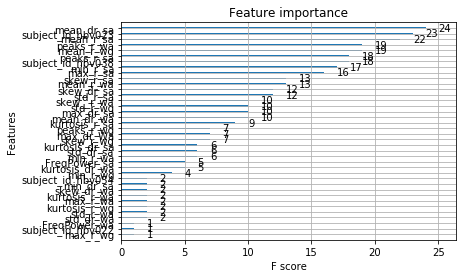

In [43]:
xgb.plot_importance(bst)


In [44]:

print("accuracy xgb:", str(metrics.accuracy_score(y_test, xgb_pred)))
print("MSE XGB:" , str(metrics.mean_squared_error(y_test,xgb_pred)))
print("NULL XGB:", str(metrics.mean_squared_error(y_test, null_test)))


accuracy xgb: 0.7972972972972973
MSE XGB: 0.44594594594594594
NULL XGB: 0.31811349761686375


In [45]:
print(metrics.confusion_matrix(y_test,xgb_pred))
print(metrics.classification_report(y_test,xgb_pred))

[[43  0  0  0]
 [ 5  1  1  2]
 [ 3  0 13  1]
 [ 0  1  2  2]]
              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91        43
         1.0       0.50      0.11      0.18         9
         2.0       0.81      0.76      0.79        17
         3.0       0.40      0.40      0.40         5

    accuracy                           0.80        74
   macro avg       0.64      0.57      0.57        74
weighted avg       0.76      0.80      0.76        74



In [51]:
param = {'objective': 'reg:squarederror',
          'max_depth': 4
        }
bst = xgb.train(param, dtrain)
xgb_pred = bst.predict(dtest)

In [52]:
print("MSE XGB:" , str(metrics.mean_squared_error(y_test,xgb_pred)))
print("NULL XGB:", str(metrics.mean_squared_error(y_test, null_test)))

MSE XGB: 0.34280410324184435
NULL XGB: 0.31811349761686375


In [53]:
xgb_pred=np.round(xgb_pred)

In [54]:
print("accuracy xgb:", str(metrics.accuracy_score(y_test, xgb_pred)))
print("MSE XGB:" , str(metrics.mean_squared_error(y_test,xgb_pred)))
print("NULL XGB:", str(metrics.mean_squared_error(y_test, null_test)))

accuracy xgb: 0.7297297297297297
MSE XGB: 0.35135135135135137
NULL XGB: 0.31811349761686375


### Testing

In [ ]:
test_subjects = pd.read_csv('testing_data\REAL-PD_Test_Data_IDs.csv')
test_subjects.head()

In [ ]:
test_subjects.subject_id.unique()==labels.subject_id.unique()

In [ ]:

#pd.read_csv(f) for f in all_filenames 

mycsvdir = 'testing_data\REAL_testing\smartphone_accelerometer'

csvfiles = glob.glob(os.path.join(mycsvdir, '*.csv'))

Means_sa=[]
for csvfile in csvfiles:
    df = pd.read_csv(csvfile)
    
    #Relevant features 
    measurement_id = os.path.basename(csvfile)
    measurement_id = measurement_id.replace(".csv","")
    
    df["r"] = np.sqrt(df.x**2+df.y**2+df.z**2)
    dr = np.sqrt(np.diff(df.x)**2+np.diff(df.y)**2+np.diff(df.z)**2)
    mean_r = np.median(df.r)
    std_r = np.std(df.r)
    min_r = np.min(df.r)
    max_r = np.max(df.r)
    skew_r = skew(df.r)
    kurtosis_r = kurtosis(df.r)
    
    mean_dr = np.median(dr)
    std_dr = np.std(dr)
    min_dr = np.min(dr)
    max_dr = np.max(dr)
    skew_dr = skew(dr)
    kurtosis_dr = kurtosis(dr)
    
    """Extract frequency bands in Hz"""
    FreqBandx = sig.lfilter(Filter[0],Filter[1],df["x"]);
    FreqBandy = sig.lfilter(Filter[0],Filter[1],df["y"]);
    FreqBandz = sig.lfilter(Filter[0],Filter[1],df["z"]);
    
    """Find the power in each frequency Band"""
    PowerFreqBandx = np.abs(FreqBandx)**2;
    PowerFreqBandy = np.abs(FreqBandy)**2;
    PowerFreqBandz = np.abs(FreqBandz)**2;
    
    """Sum the power in each frequency band"""
    SumPowerFreqBandx = np.sum(PowerFreqBandx);
    SumPowerFreqBandy = np.sum(PowerFreqBandy);
    SumPowerFreqBandz = np.sum(PowerFreqBandz);
    
    """Sum the total signal power"""
    Powerx = np.sum(df["x"]**2);
    Powery = np.sum(df["y"]**2);
    Powerz = np.sum(df["z"]**2);
    
    """Find the percentage of power in frequencies of interest"""
    FreqPower = np.sqrt((SumPowerFreqBandx+SumPowerFreqBandy+SumPowerFreqBandz)/(Powerx+Powery+Powerz));
    
    Means_sa.append([measurement_id, mean_r, std_r, min_r, max_r, skew_r, kurtosis_r, 
                     mean_dr,std_dr, min_dr, max_dr, skew_dr, kurtosis_dr,FreqPower])

   

In [ ]:
accel_phones_test= pd.DataFrame(Means_sa, columns=["measurement_id", "mean_r_sa", "std_r_sa", 
                                              "min_r_sa", "max_r_sa", "skew_r_sa", "kurtosis_r_sa",
                                              "mean_dr_sa", "std_dr_sa", "min_dr_sa", "max_dr_sa", 
                                              "skew_dr_sa", "kurtosis_dr_sa","FreqPower_sa"])
   


In [ ]:
accel_phones_test.head()

In [ ]:

#pd.read_csv(f) for f in all_filenames 

mycsvdir = 'testing_data\REAL_testing\smartwatch_accelerometer'

csvfiles = glob.glob(os.path.join(mycsvdir, '*.csv'))

Means_wa=[]
for csvfile in csvfiles:
    df1 = pd.read_csv(csvfile)
    
    for x in pd.Series(df1['device_id']).unique():
        
        df = df1[df1['device_id']==x]
        """Apply Hypothesis tests to check if means are statistically significant????"""
        #Relevant features 
        measurement_id = os.path.basename(csvfile)
        measurement_id = measurement_id.replace(".csv","")

        device_id = x
        
        df["r"] = np.sqrt(df.x**2+df.y**2+df.z**2)
        dr = np.sqrt(np.diff(df.x)**2+np.diff(df.y)**2+np.diff(df.z)**2)

        mean_r = np.mean(df.r)
        std_r = np.std(df.r)
        min_r = np.min(df.r)
        max_r = np.max(df.r)
        skew_r = skew(df.r)
        kurtosis_r = kurtosis(df.r)

        mean_dr = np.mean(dr)
        std_dr = np.std(dr)
        min_dr = np.min(dr)
        max_dr = np.max(dr)
        skew_dr = skew(dr)
        kurtosis_dr = kurtosis(dr)
        
        """Extract frequency bands in Hz"""
        FreqBandx = sig.lfilter(Filter[0],Filter[1],df["x"]);
        FreqBandy = sig.lfilter(Filter[0],Filter[1],df["y"]);
        FreqBandz = sig.lfilter(Filter[0],Filter[1],df["z"]);

        """Find the power in each frequency Band"""
        PowerFreqBandx = np.abs(FreqBandx)**2;
        PowerFreqBandy = np.abs(FreqBandy)**2;
        PowerFreqBandz = np.abs(FreqBandz)**2;

        """Sum the power in each frequency band"""
        SumPowerFreqBandx = np.sum(PowerFreqBandx);
        SumPowerFreqBandy = np.sum(PowerFreqBandy);
        SumPowerFreqBandz = np.sum(PowerFreqBandz);

        """Sum the total signal power"""
        Powerx = np.sum(df["x"]**2);
        Powery = np.sum(df["y"]**2);
        Powerz = np.sum(df["z"]**2);

        """Find the percentage of power in frequencies of interest"""
        FreqPower = np.sqrt((SumPowerFreqBandx+SumPowerFreqBandy+SumPowerFreqBandz)/(Powerx+Powery+Powerz));

        Means_wa.append([measurement_id, device_id, mean_r, std_r, min_r, max_r, skew_r, kurtosis_r, 
                         mean_dr,std_dr, min_dr, max_dr, skew_dr, kurtosis_dr,FreqPower])


    
        

In [ ]:
accel_watches_test = pd.DataFrame(Means_wa, columns=["measurement_id","device_id", "mean_r_wa", "std_r_wa", 
                                              "min_r_wa", "max_r_wa", "skew__r_wa", "kurtosis_r_wa",
                                              "mean_dr_wa", "std_dr_wa", "min_dr_wa", "max_dr_Wa", 
                                              "skew_dr_wa", "kurtosis_dr_wa","FreqPower_wa"])
   



In [ ]:
#pd.read_csv(f) for f in all_filenames 

mycsvdir = 'testing_data\REAL_testing\smartwatch_gyroscope'

csvfiles = glob.glob(os.path.join(mycsvdir, '*.csv'))

Means_wg=[]
for csvfile in csvfiles:
    df1 = pd.read_csv(csvfile)
    
    for x in pd.Series(df1['device_id']).unique():
        
        df = df1[df1['device_id']==x]
         
        #Relevant features 
        measurement_id = os.path.basename(csvfile)
        measurement_id = measurement_id.replace(".csv","")
        device_id = x

        df["r"] = np.sqrt(df.x**2+df.y**2+df.z**2)
        mean_r = np.mean(df.r)
        std_r = np.std(df.r)
        min_r = np.min(df.r)
        max_r = np.max(df.r)
        skew_r = skew(df.r)
        kurtosis_r = kurtosis(df.r)
    
        Means_wg.append([measurement_id,device_id, mean_r, std_r, min_r, max_r, skew_r, kurtosis_r])
       

In [ ]:
gyro_watches_test= pd.DataFrame(Means_wg, columns=["measurement_id", "device_id", "mean_r_wg", "std_r_wg", 
                                              "min_r_wg", "max_r_wg", "skew_r_wg", "kurtosis_r_wg"])
   



In [ ]:
df_watch_test=pd.merge(gyro_watches_test, accel_watches_test, on=["measurement_id", "device_id"])
df_watch_test.shape

In [ ]:
df_test=pd.merge(df_watch_test, accel_phones_test, on=['measurement_id'], how='outer')
df_test.shape

In [ ]:
df_test_data = pd.merge(df_test, test_subjects, on =['measurement_id'])
df_test_data.shape

In [ ]:
df_test_data.subject_id.unique()

In [ ]:
train = df_tremor.drop(['measurement_id', 'device_id', 'tremor', 'tremor_null'], axis=1)
train.head()

In [ ]:
cols_train = train.columns[:-1]
scaler= scaler.fit(df_tremor[cols_train])
train[cols_train] = scaler.transform(train[cols_train])
train.head()

In [ ]:
cols_test=df_test_data.columns[2:-1]
df_test_data[cols_test]=scaler.transform(df_test_data[cols_test])

In [ ]:
df_test_data.head()

In [ ]:
train = pd.get_dummies(train)

In [ ]:

df_test_predict= pd.get_dummies(df_test_data[df_test_data.columns[2:]])
df_test_predict.head()

In [ ]:
df_test_data.subject_id.unique()

In [ ]:
df_tremor.subject_id.unique()

In [ ]:
df_test_predict = df_test_predict.drop(['subject_id_hbv051', 'subject_id_hbv077', 'subject_id_hbv018', 
                      'subject_id_hbv043', 'subject_id_hbv014', 'subject_id_hbv017'], 
                    axis = 1)


In [ ]:
df_test_predict.shape

In [ ]:
df_train_imputed = pd.DataFrame(imputer.fit_transform(train), columns = train.columns)
df_train_imputed.shape

In [ ]:
df_test_imputed=pd.DataFrame(imputer.fit_transform(df_test_predict), columns = df_test_predict.columns)
df_test_imputed.shape

In [ ]:
dtrain=xgb.DMatrix(data=df_train_imputed, label=df_tremor.tremor)
dtest = xgb.DMatrix(data=df_test_imputed)

In [ ]:
bst = xgb.train(param, dtrain)
xgb_pred = bst.predict(dtest)

In [ ]:

df_test_data["prediction"]=xgb_pred
df_test_data.head()

In [ ]:
test_subjects.shape

In [ ]:
df_predictions = pd.merge(df_test_data[['measurement_id', 'prediction']], test_subjects, on=['measurement_id'], how ="right")

In [ ]:
len(df_predictions.measurement_id.unique())

In [ ]:
df_predictions.shape

In [ ]:
df_predictions.drop_duplicates(subset ="measurement_id", inplace=True) 

In [ ]:
df_predictions.shape

In [ ]:
df_predictions.head()

In [ ]:
df_predictions[['measurement_id','prediction']].to_csv("real_pd_tremor_predictions.csv", index=False)